# Suitability Filter Experiments

In [1]:
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import ResNet50_Weights, resnet50

from suitability.baselines.ac import AverageConfidence
from suitability.baselines.atc import AverageThresholdConfidence
from suitability.baselines.doc import DifferenceOfConfidence
from suitability.baselines.doe import DifferenceOfEntropy
from suitability.baselines.mde import MetaDistributionEnergy
from suitability.filter import suitability

importlib.reload(suitability)

from suitability.filter.suitability import SuitabilityFilter

random.seed(32)
np.random.seed(32)

## Define data and model

In [2]:
root_dir = "/mfsnic/datasets/imagenet/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model = model.to(device)
model.eval()

transform = transforms.Compose(
    [
        transforms.Resize(
            size=(232, 232), interpolation=transforms.InterpolationMode.BILINEAR
        ),
        transforms.CenterCrop(size=(224, 224)),
        transforms.ToTensor(),  # Convert to Tensor and scale to [0, 1]
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalize
    ]
)

imagenet_data = torchvision.datasets.ImageNet(
    root_dir, split="val", transform=transform
)
test, regressor, user = random_split(imagenet_data, [0.25, 0.25, 0.5])
test_data = DataLoader(test, batch_size=64, shuffle=False, num_workers=4)
regressor_data = DataLoader(regressor, batch_size=64, shuffle=True, num_workers=4)

## Initialize suitability filter

In [3]:
suitability_filter = SuitabilityFilter(model, test_data, regressor_data, device)
test_features, test_corr = suitability_filter.get_features(test_data)
suitability_filter.train_regressor()

In [ ]:
average_confidence = AverageConfidence(model, test_data, device)
average_threshold_confidence = AverageThresholdConfidence(model, test_data, device)
difference_of_confidence = DifferenceOfConfidence(model, test_data, device)
difference_of_entropy = DifferenceOfEntropy(model, test_data, device)
meta_distribution_energy = MetaDistributionEnergy(model, test_data, device)

## Evaluate the suitability filter

### IID Evaluation

In [4]:
dataloader = DataLoader(user, batch_size=64, shuffle=False, num_workers=4)
all_user_features, all_user_corr = suitability_filter.get_features(dataloader)

In [5]:
def split_dataset_into_folds(correctness, target_accuracies):
    # Define target accuracies
    n_subsets = len(target_accuracies)
    total_samples = len(correctness)

    # Shuffle the indices and the correctness array
    indices = np.random.permutation(total_samples)
    shuffled_correctness = correctness[indices]

    # Initialize subsets
    folds = []
    subsets_correctness = []

    start_idx = 0
    for i, target_accuracy in enumerate(target_accuracies):
        # Calculate the number of correct and incorrect samples needed for the subset
        subset_size = total_samples // n_subsets
        n_correct = int(subset_size * target_accuracy)
        n_incorrect = subset_size - n_correct

        # Find the correct/incorrect samples in the shuffled data
        remaining_correct_indices = np.where(shuffled_correctness[start_idx:] == 1)[0]
        remaining_incorrect_indices = np.where(shuffled_correctness[start_idx:] == 0)[0]

        # Adjust n_correct and n_incorrect based on available samples
        n_correct = min(n_correct, len(remaining_correct_indices))
        n_incorrect = min(n_incorrect, len(remaining_incorrect_indices))

        # Get the actual indices for the current subset
        correct_indices = remaining_correct_indices[:n_correct]
        incorrect_indices = remaining_incorrect_indices[:n_incorrect]

        # Get the final indices for the current subset
        subset_indices = (
            np.concatenate((correct_indices, incorrect_indices)) + start_idx
        )

        # Extract the correctness for the current subset
        folds.append(indices[subset_indices])
        subsets_correctness.append(np.mean(shuffled_correctness[subset_indices]))

        # Move the start index forward
        start_idx += len(subset_indices)

    return folds, subsets_correctness

In [ ]:
# Construct suitability filter
num_random_tries = 100
target_accuracies = np.arange(0.78, 0.83, 0.005)
num_folds = len(target_accuracies)

acs = np.zeros((num_random_tries, num_folds))
corrs = np.zeros((num_random_tries, num_folds))
p_vals = np.zeros((num_random_tries, num_folds))
p_vals_margin1 = np.zeros((num_random_tries, num_folds))
p_vals_margin2 = np.zeros((num_random_tries, num_folds))
p_vals_margin3 = np.zeros((num_random_tries, num_folds))
p_vals_margin4 = np.zeros((num_random_tries, num_folds))
p_vals_2k_samples = np.zeros((num_random_tries, num_folds))
p_vals_15k_samples = np.zeros((num_random_tries, num_folds))
p_vals_1k_samples = np.zeros((num_random_tries, num_folds))

for j in range(num_random_tries):
    folds, actual_accuracies = split_dataset_into_folds(
        all_user_corr, target_accuracies=target_accuracies
    )

    for i, fold_indices in enumerate(folds):
        # Select features for the current fold
        user_features = all_user_features[fold_indices]
        np.random.shuffle(user_features)
        user_corr = all_user_corr[fold_indices]

        acs[j, i] = np.mean(user_features, axis=0)[1]
        corrs[j, i] = np.mean(user_corr)
        test = suitability_filter.suitability_test(user_features=user_features)
        p_vals[j, i] = test["p_value"]
        test1 = suitability_filter.suitability_test(
            user_features=user_features, margin=0.01
        )
        p_vals_margin1[j, i] = test1["p_value"]
        test2 = suitability_filter.suitability_test(
            user_features=user_features, margin=0.02
        )
        p_vals_margin2[j, i] = test2["p_value"]
        test3 = suitability_filter.suitability_test(
            user_features=user_features, margin=0.03
        )
        p_vals_margin3[j, i] = test3["p_value"]
        test4 = suitability_filter.suitability_test(
            user_features=user_features, margin=0.04
        )
        p_vals_margin4[j, i] = test4["p_value"]
        p_vals_2k_samples[j, i] = suitability_filter.suitability_test(
            user_features=user_features[:2000]
        )["p_value"]
        p_vals_15k_samples[j, i] = suitability_filter.suitability_test(
            user_features=user_features[:1500]
        )["p_value"]
        p_vals_1k_samples[j, i] = suitability_filter.suitability_test(
            user_features=user_features[:1000]
        )["p_value"]


In [52]:
test_ac = np.mean(test_features, axis=0)[1]
test_corr = np.mean(test_corr)

In [ ]:
def get_fpr_fnr(actual_accuracies, p_vals, alpha=0.05):
    fpr = 0
    fnr = 0
    for i, acc in enumerate(actual_accuracies):
        if acc < test_corr:
            fpr += np.sum(p_vals[:, i] < alpha) / (p_vals.shape[0] * p_vals.shape[1])
        else:
            fnr += np.sum(p_vals[:, i] >= alpha) / (p_vals.shape[0] * p_vals.shape[1])
    return fpr, fnr

In [ ]:
fpracs, fnracs = 0, 0

for i, acc in enumerate(actual_accuracies):
    if acc < test_corr:
        fpracs += np.sum(acs[:, i] >= test_ac) / (acs.shape[0] * acs.shape[1])
    else:
        fnracs += np.sum(acs[:, i] < test_ac) / (acs.shape[0] * acs.shape[1])

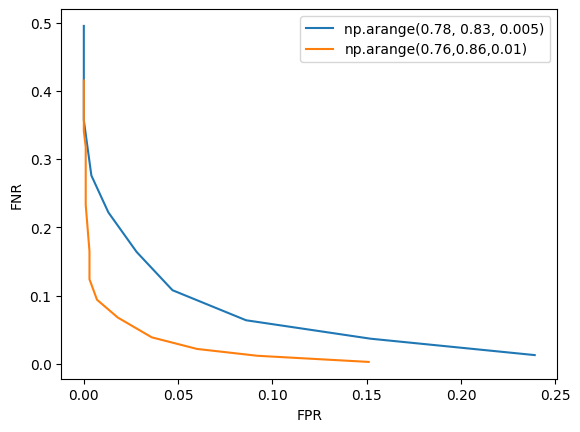

In [ ]:
fprs = []
fprs_margin1 = []
fprs_margin2 = []
fprs_margin3 = []
fprs_margin4 = []
fprs_2k_samples = []
fprs_15k_samples = []
fprs_1k_samples = []
fnrs = []
fnrs_margin1 = []
fnrs_margin2 = []
fnrs_margin3 = []
fnrs_margin4 = []
fnrs_2k_samples = []
fnrs_15k_samples = []
fnrs_1k_samples = []


for a in [
    0.01,
    0.02,
    0.03,
    0.04,
    0.05,
    0.06,
    0.07,
    0.08,
    0.09,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
]:
    fpr, fnr = get_fpr_fnr(actual_accuracies, p_vals, alpha=a)
    fprs.append(fpr)
    fnrs.append(fnr)
    fpr1, fnr1 = get_fpr_fnr(actual_accuracies, p_vals_margin1, alpha=a)
    fprs_margin1.append(fpr1)
    fnrs_margin1.append(fnr1)
    fpr2, fnr2 = get_fpr_fnr(actual_accuracies, p_vals_margin2, alpha=a)
    fprs_margin2.append(fpr2)
    fnrs_margin2.append(fnr2)
    fpr3, fnr3 = get_fpr_fnr(actual_accuracies, p_vals_margin3, alpha=a)
    fprs_margin3.append(fpr3)
    fnrs_margin3.append(fnr3)
    fpr4, fnr4 = get_fpr_fnr(actual_accuracies, p_vals_margin4, alpha=a)
    fprs_margin4.append(fpr4)
    fnrs_margin4.append(fnr4)
    fpr2k, fnr2k = get_fpr_fnr(actual_accuracies, p_vals_2k_samples, alpha=a)
    fprs_2k_samples.append(fpr2k)
    fnrs_2k_samples.append(fnr2k)
    fpr15k, fnr15k = get_fpr_fnr(actual_accuracies, p_vals_15k_samples, alpha=a)
    fprs_15k_samples.append(fpr15k)
    fnrs_15k_samples.append(fnr15k)
    fpr1k, fnr1k = get_fpr_fnr(actual_accuracies, p_vals_1k_samples, alpha=a)
    fprs_1k_samples.append(fpr1k)
    fnrs_1k_samples.append(fnr1k)


plt.plot(fprs, fnrs, label="np.arange(0.78, 0.83, 0.005)")
plt.plot(fprs_old, fnrs_old, label="np.arange(0.76,0.86,0.01)")
# plt.plot(fprs_margin1, fnrs_margin1, label="0.01 margin")
# plt.plot(fprs_margin2, fnrs_margin2, label="0.02 margin")
# plt.plot(fprs_margin3, fnrs_margin3, label="0.03 margin")
# plt.plot(fprs_margin4, fnrs_margin4, label="0.04 margin")
# plt.plot(fprs_2k_samples, fnrs_2k_samples, label="2k samples")
# plt.plot(fprs_15k_samples, fnrs_15k_samples, label="1.5k samples")
# plt.plot(fprs_1k_samples, fnrs_1k_samples, label="1k samples")
# plt.plot(fpracs, fnracs, 'ro', label="AC")
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.legend()
plt.show()

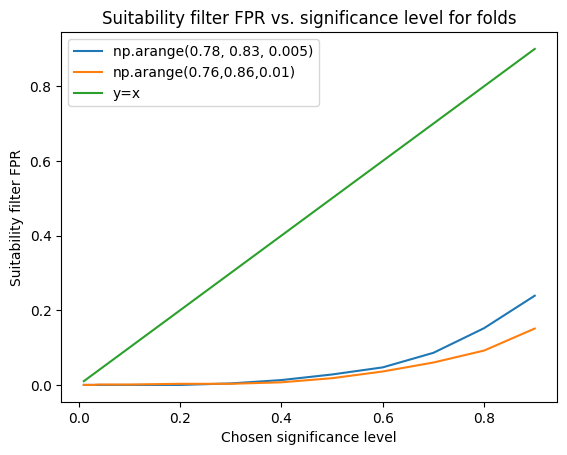

In [ ]:
sig_level = [
    0.01,
    0.02,
    0.03,
    0.04,
    0.05,
    0.06,
    0.07,
    0.08,
    0.09,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
]
plt.plot(sig_level, fprs, label="np.arange(0.78, 0.83, 0.005)")
plt.plot(sig_level, fprs_old, label="np.arange(0.76,0.86,0.01)")
plt.plot(sig_level, sig_level, label="y=x")
plt.xlabel("Chosen significance level")
plt.ylabel("Suitability filter FPR")
plt.title("Suitability filter FPR vs. significance level for folds")
plt.legend()
plt.show()

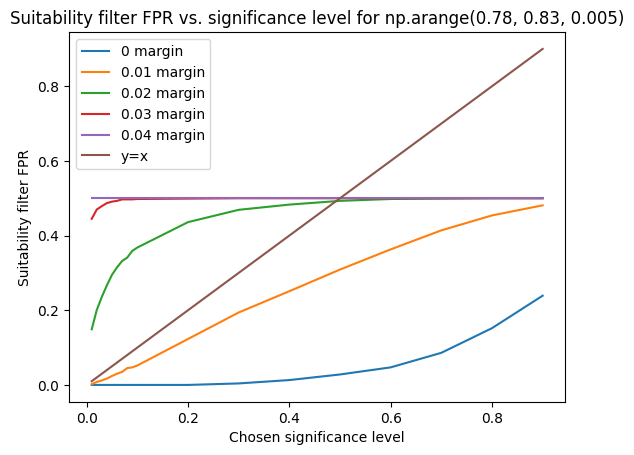

In [ ]:
sig_level = [
    0.01,
    0.02,
    0.03,
    0.04,
    0.05,
    0.06,
    0.07,
    0.08,
    0.09,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
]
plt.plot(sig_level, fprs, label="0 margin")
plt.plot(sig_level, fprs_margin1, label="0.01 margin")
plt.plot(sig_level, fprs_margin2, label="0.02 margin")
plt.plot(sig_level, fprs_margin3, label="0.03 margin")
plt.plot(sig_level, fprs_margin4, label="0.04 margin")
plt.plot(sig_level, sig_level, label="y=x")
plt.xlabel("Chosen significance level")
plt.ylabel("Suitability filter FPR")
plt.title(
    "Suitability filter FPR vs. significance level for np.arange(0.78, 0.83, 0.005)"
)
plt.legend()
plt.show()

In [19]:
x = []
yp01 = []
yp02 = []
yp03 = []
yp04 = []
yp05 = []
yp06 = []
yp07 = []
yp08 = []
yp09 = []
yp10 = []
yp20 = []
yp30 = []
yp40 = []
ya = []

for i in range(num_folds):
    x.append(corrs[:, i].mean())
    yp01.append(np.sum(p_vals[:, i] < 0.01))
    yp02.append(np.sum(p_vals[:, i] < 0.02))
    yp03.append(np.sum(p_vals[:, i] < 0.03))
    yp04.append(np.sum(p_vals[:, i] < 0.04))
    yp05.append(np.sum(p_vals[:, i] < 0.05))
    yp06.append(np.sum(p_vals[:, i] < 0.06))
    yp07.append(np.sum(p_vals[:, i] < 0.07))
    yp08.append(np.sum(p_vals[:, i] < 0.08))
    yp09.append(np.sum(p_vals[:, i] < 0.09))
    yp10.append(np.sum(p_vals[:, i] < 0.1))
    yp20.append(np.sum(p_vals[:, i] < 0.2))
    yp30.append(np.sum(p_vals[:, i] < 0.3))
    yp40.append(np.sum(p_vals[:, i] < 0.4))

    ya.append(np.sum(acs[:, i] > test_ac))

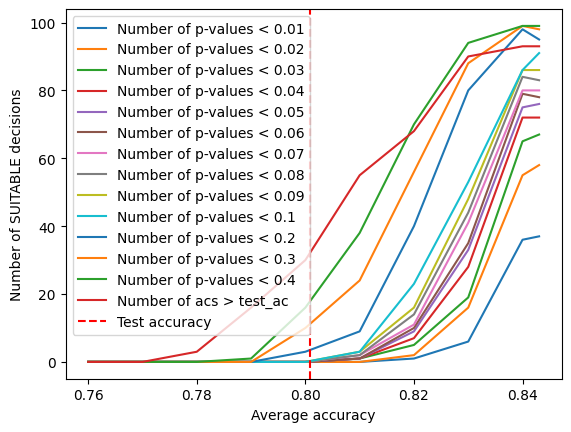

In [ ]:
plt.plot(x, yp01, label="Number of p-values < 0.01")
plt.plot(x, yp02, label="Number of p-values < 0.02")
plt.plot(x, yp03, label="Number of p-values < 0.03")
plt.plot(x, yp04, label="Number of p-values < 0.04")
plt.plot(x, yp05, label="Number of p-values < 0.05")
plt.plot(x, yp06, label="Number of p-values < 0.06")
plt.plot(x, yp07, label="Number of p-values < 0.07")
plt.plot(x, yp08, label="Number of p-values < 0.08")
plt.plot(x, yp09, label="Number of p-values < 0.09")
plt.plot(x, yp10, label="Number of p-values < 0.1")
plt.plot(x, yp20, label="Number of p-values < 0.2")
plt.plot(x, yp30, label="Number of p-values < 0.3")
plt.plot(x, yp40, label="Number of p-values < 0.4")
plt.plot(x, ya, label="Number of acs > test_ac")
plt.xlabel("Average accuracy")
plt.ylabel("Number of SUITABLE decisions")
plt.axvline(test_corr, color="r", linestyle="--", label="Test accuracy")
plt.legend()
plt.show()

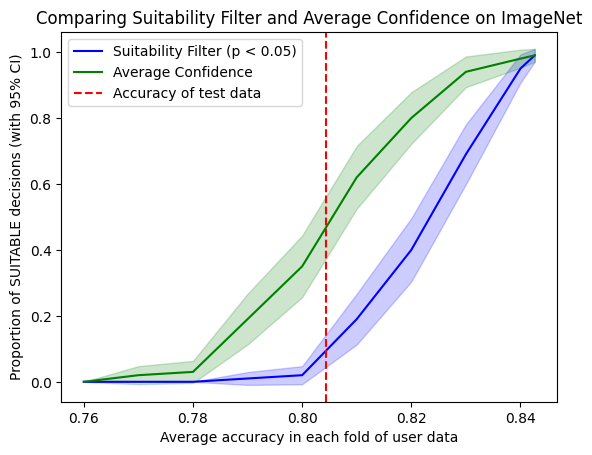

In [ ]:
x = []
yp_mean = []
yp_ci = []
ya_mean = []
ya_ci = []

# Loop over folds to calculate the means and 95% CIs for each decision type
for i in range(num_folds):
    avg_accuracy = corrs[:, i].mean()
    x.append(avg_accuracy)

    # Significant p-values decision (p < 0.05)
    p_sig_decision = p_vals[:, i] < 0.05
    p_sig_mean = np.mean(p_sig_decision)
    p_sig_sem = np.std(p_sig_decision) / np.sqrt(len(p_sig_decision))
    p_sig_ci = 1.96 * p_sig_sem  # 95% confidence interval
    yp_mean.append(p_sig_mean)
    yp_ci.append(p_sig_ci)

    # Accuracy exceeds test_ac decision (acs > test_ac)
    ac_exceeds_test = acs[:, i] > test_ac
    ac_exceeds_mean = np.mean(ac_exceeds_test)
    ac_exceeds_sem = np.std(ac_exceeds_test) / np.sqrt(len(ac_exceeds_test))
    ac_exceeds_ci = 1.96 * ac_exceeds_sem  # 95% confidence interval
    ya_mean.append(ac_exceeds_mean)
    ya_ci.append(ac_exceeds_ci)

# Convert lists to arrays for fill_between to work
x = np.array(x)
yp_mean = np.array(yp_mean)
yp_ci = np.array(yp_ci)
ya_mean = np.array(ya_mean)
ya_ci = np.array(ya_ci)

# Plotting
plt.plot(x, yp_mean, label="Suitability Filter (p < 0.05)", color="blue")
plt.fill_between(x, yp_mean - yp_ci, yp_mean + yp_ci, color="blue", alpha=0.2)

plt.plot(x, ya_mean, label="Average Confidence", color="green")
plt.fill_between(x, ya_mean - ya_ci, ya_mean + ya_ci, color="green", alpha=0.2)

plt.xlabel("Average accuracy in each fold of user data")
plt.ylabel("Proportion of SUITABLE decisions (with 95% CI)")
plt.axvline(test_corr, color="r", linestyle="--", label="Accuracy of test data")
plt.title("Comparing Suitability Filter and Average Confidence on ImageNet")
plt.legend()
plt.show()

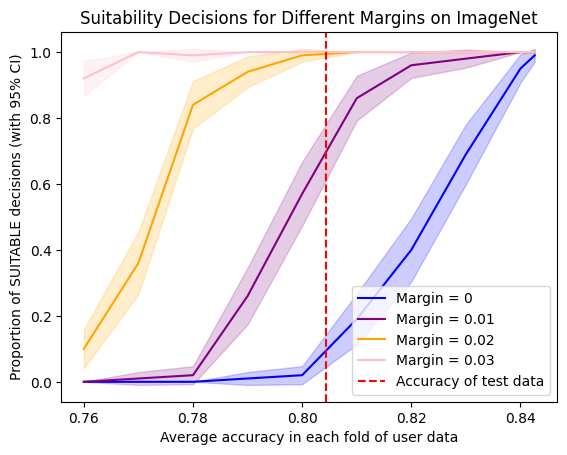

In [ ]:
# Prepare lists to store results for each type of decision and margin
x = []
yp_mean = []
yp_ci = []
ya_mean = []
ya_ci = []
y_margin1_mean = []
y_margin1_ci = []
y_margin2_mean = []
y_margin2_ci = []
y_margin3_mean = []
y_margin3_ci = []
y_margin4_mean = []
y_margin4_ci = []

# Loop over folds to calculate the means and 95% CIs for each decision type
for i in range(num_folds):
    avg_accuracy = corrs[:, i].mean()
    x.append(avg_accuracy)

    # Significant p-values decision (p < 0.05)
    p_sig_decision = p_vals[:, i] < 0.05
    p_sig_mean = np.mean(p_sig_decision)
    p_sig_sem = np.std(p_sig_decision) / np.sqrt(len(p_sig_decision))
    p_sig_ci = 1.96 * p_sig_sem  # 95% confidence interval
    yp_mean.append(p_sig_mean)
    yp_ci.append(p_sig_ci)

    # Accuracy exceeds test_ac decision (acs > test_ac)
    ac_exceeds_test = acs[:, i] > test_ac
    ac_exceeds_mean = np.mean(ac_exceeds_test)
    ac_exceeds_sem = np.std(ac_exceeds_test) / np.sqrt(len(ac_exceeds_test))
    ac_exceeds_ci = 1.96 * ac_exceeds_sem
    ya_mean.append(ac_exceeds_mean)
    ya_ci.append(ac_exceeds_ci)

    # Margins 0.01 to 0.04
    for margin, mean_list, ci_list, p_values in zip(
        [p_vals_margin1, p_vals_margin2, p_vals_margin3, p_vals_margin4],
        [y_margin1_mean, y_margin2_mean, y_margin3_mean, y_margin4_mean],
        [y_margin1_ci, y_margin2_ci, y_margin3_ci, y_margin4_ci],
        [
            p_vals_margin1[:, i],
            p_vals_margin2[:, i],
            p_vals_margin3[:, i],
            p_vals_margin4[:, i],
        ],
    ):
        margin_decision = p_values < 0.05
        margin_mean = np.mean(margin_decision)
        margin_sem = np.std(margin_decision) / np.sqrt(len(margin_decision))
        margin_ci = 1.96 * margin_sem
        mean_list.append(margin_mean)
        ci_list.append(margin_ci)

# Convert lists to arrays for fill_between to work
x = np.array(x)
yp_mean, yp_ci = np.array(yp_mean), np.array(yp_ci)
ya_mean, ya_ci = np.array(ya_mean), np.array(ya_ci)
y_margin1_mean, y_margin1_ci = np.array(y_margin1_mean), np.array(y_margin1_ci)
y_margin2_mean, y_margin2_ci = np.array(y_margin2_mean), np.array(y_margin2_ci)
y_margin3_mean, y_margin3_ci = np.array(y_margin3_mean), np.array(y_margin3_ci)
y_margin4_mean, y_margin4_ci = np.array(y_margin4_mean), np.array(y_margin4_ci)

# Plotting
plt.plot(x, yp_mean, label="Margin = 0", color="blue")
plt.fill_between(x, yp_mean - yp_ci, yp_mean + yp_ci, color="blue", alpha=0.2)

plt.plot(x, y_margin1_mean, label="Margin = 0.01", color="purple")
plt.fill_between(
    x,
    y_margin1_mean - y_margin1_ci,
    y_margin1_mean + y_margin1_ci,
    color="purple",
    alpha=0.2,
)

plt.plot(x, y_margin2_mean, label="Margin = 0.02", color="orange")
plt.fill_between(
    x,
    y_margin2_mean - y_margin2_ci,
    y_margin2_mean + y_margin2_ci,
    color="orange",
    alpha=0.2,
)

plt.plot(x, y_margin3_mean, label="Margin = 0.03", color="pink")
plt.fill_between(
    x,
    y_margin3_mean - y_margin3_ci,
    y_margin3_mean + y_margin3_ci,
    color="pink",
    alpha=0.2,
)

# plt.plot(x, y_margin4_mean, label="Margin = 0.04", color="cyan")
# plt.fill_between(x, y_margin4_mean - y_margin4_ci, y_margin4_mean + y_margin4_ci, color="cyan", alpha=0.2)

plt.xlabel("Average accuracy in each fold of user data")
plt.ylabel("Proportion of SUITABLE decisions (with 95% CI)")
plt.axvline(test_corr, color="r", linestyle="--", label="Accuracy of test data")
plt.title("Suitability Decisions for Different Margins on ImageNet")
plt.legend()
plt.show()


#### Baselines comparison

In [ ]:
# Construct suitability filter
step_size = 0.01
test_acc = np.mean(test_corr)
accs = np.arange(
    test_acc - step_size / 2 - 4 * step_size,
    test_acc + step_size / 2 + 5 * step_size,
    step_size,
)

num_random_tries = 100
target_accuracies = accs  # np.arange(0.78, 0.83, 0.005), np.arange(0.798, 0.807, 0.001)
num_acc_folds = len(target_accuracies)
target_sample_sizes = np.array([1000, 1500, 2000, 2500])
num_sample_folds = len(target_sample_sizes)
target_margins = np.array([0])  # np.array([0, 0.001, 0.005, 0.01, 0.015, 0.02])
num_margin_folds = len(target_margins)

corrs = np.zeros((num_random_tries, num_acc_folds))
p_vals = np.zeros((num_random_tries, num_acc_folds, num_sample_folds, num_margin_folds))
sf_est = np.zeros((num_random_tries, num_acc_folds, num_sample_folds, num_margin_folds))
ac = np.zeros((num_random_tries, num_acc_folds, num_sample_folds))
atc = np.zeros((num_random_tries, num_acc_folds, num_sample_folds))
doc = np.zeros((num_random_tries, num_acc_folds, num_sample_folds))
doe = np.zeros((num_random_tries, num_acc_folds, num_sample_folds))
mde = np.zeros((num_random_tries, num_acc_folds, num_sample_folds))

for j in range(num_random_tries):
    folds, actual_accuracies = split_dataset_into_folds(
        all_user_corr, target_accuracies=target_accuracies
    )
    corrs[j] = np.array(actual_accuracies)

    for i, fold_indices in enumerate(folds):
        user_features = all_user_features[fold_indices]

        user_conf = user_features[:, 0]
        user_entropy = user_features[:, 2]
        user_energy = user_features[:, -1]
        user_corr = all_user_corr[fold_indices]

        for s, num_samples in enumerate(target_sample_sizes):
            np.random.shuffle(user_features)
            ac[j, i, s] = average_confidence.evaluate(
                user_confidences=user_conf[:num_samples]
            )
            atc[j, i, s] = average_threshold_confidence.evaluate(
                user_confidences=user_conf[:num_samples]
            )
            doc[j, i, s] = difference_of_confidence.estimate_performance(
                user_confidences=user_conf[:num_samples]
            )
            doe[j, i, s] = difference_of_entropy.estimate_performance(
                user_entropies=user_entropy[:num_samples]
            )
            mde[j, i, s] = meta_distribution_energy.estimate_performance(
                user_energies=user_energy[:num_samples]
            )

            for m, margin in enumerate(target_margins):
                test = suitability_filter.suitability_test(
                    user_features=user_features[:num_samples],
                    margin=margin,
                    return_predictions=True,
                )
                p_vals[j, i, s, m] = test["p_value"]
                sf_est[j, i, s, m] = np.mean(test["user_predictions"])

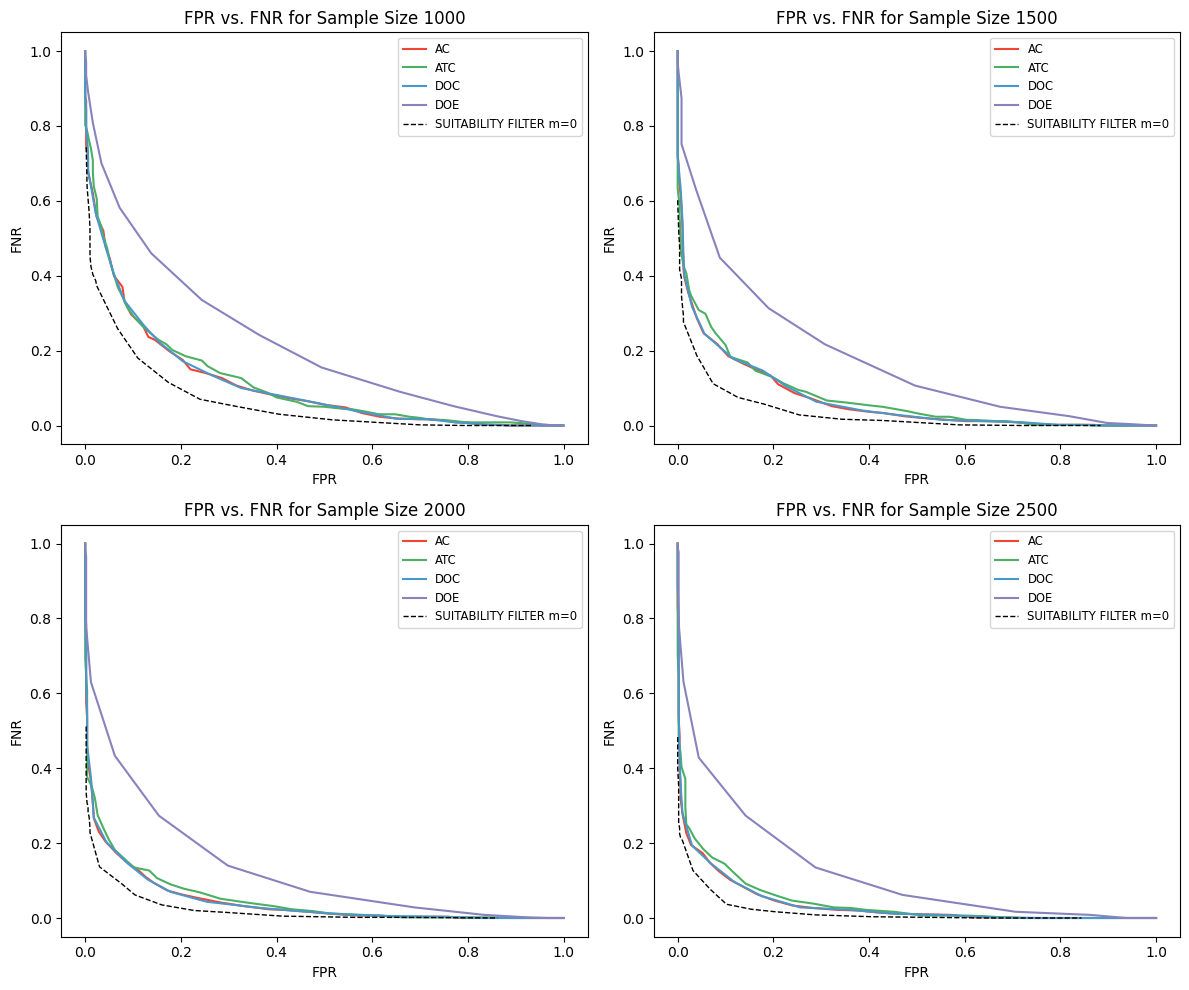

In [ ]:
# Color maps for each method
method_colors = [
    plt.cm.Reds,
    plt.cm.Greens,
    plt.cm.Blues,
    plt.cm.Purples,
    plt.cm.Oranges,
]
labels = ["AC", "ATC", "DOC", "DOE", "MDE"]

# Construct ground truth
ground_truth = corrs >= np.mean(test_corr)


def get_fpr_fnr(decisions, ground_truth):
    decisions, ground_truth = decisions.flatten(), ground_truth.flatten()
    fpr = np.sum(np.logical_and(decisions == 1, ground_truth == 0)) / np.sum(
        ground_truth == 0
    )
    fnr = np.sum(np.logical_and(decisions == 0, ground_truth == 1)) / np.sum(
        ground_truth == 1
    )
    return fpr, fnr


def get_fpr_fnr_margins(
    estimates, threshold, ground_truth, margins=np.arange(-0.05, 0.05, 0.001)
):
    fprs = []
    fnrs = []
    for m in margins:
        decisions = estimates >= threshold - m
        fpr, fnr = get_fpr_fnr(decisions, ground_truth)
        fprs.append(fpr)
        fnrs.append(fnr)
    return fprs, fnrs


# Create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for s, num_samples in enumerate(target_sample_sizes):
    ax = axes[s]
    datasets = [ac, atc, doc, doe]

    # Plot each method with a unique color
    for i, data in enumerate(datasets):
        color = method_colors[i](0.6)  # Adjust the color intensity
        if i != 0:
            threshold = np.mean(test_corr)
            fpr_fnr = get_fpr_fnr_margins(data[:, :, s], threshold, ground_truth)
        else:
            threshold = np.mean(test_features[:, 0])
            fpr_fnr = get_fpr_fnr_margins(
                data[:, :, s],
                threshold,
                ground_truth,
                margins=np.arange(-0.02, 0.02, 0.0005),
            )
        ax.plot(*fpr_fnr, label=f"{labels[i]}", color=color, linestyle="-")

    # Plot suitability filter line for the sample size
    for m in range(num_margin_folds):
        if m > 0:
            continue
        sf_fpr = []
        sf_fnr = []
        ground_truth_m = corrs >= np.mean(test_corr) - target_margins[m]
        for sig_level in [
            0.01,
            0.02,
            0.03,
            0.04,
            0.05,
            0.06,
            0.07,
            0.08,
            0.09,
            0.1,
            0.2,
            0.3,
            0.4,
            0.5,
            0.6,
            0.7,
            0.8,
            0.9,
            0.95,
            0.99,
        ]:
            fpr, fnr = get_fpr_fnr(p_vals[:, :, s, m] < sig_level, ground_truth_m)
            sf_fpr.append(fpr)
            sf_fnr.append(fnr)

        # Plot suitability filter line with different style
        ax.plot(
            sf_fpr,
            sf_fnr,
            color="black",
            linestyle="--",
            linewidth=1,
            label=f"SUITABILITY FILTER m={target_margins[m]}",
        )

    # Labels and title for each subplot
    ax.set_xlabel("FPR")
    ax.set_ylabel("FNR")
    ax.set_title(f"FPR vs. FNR for Sample Size {num_samples}")
    ax.legend(fontsize="small")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

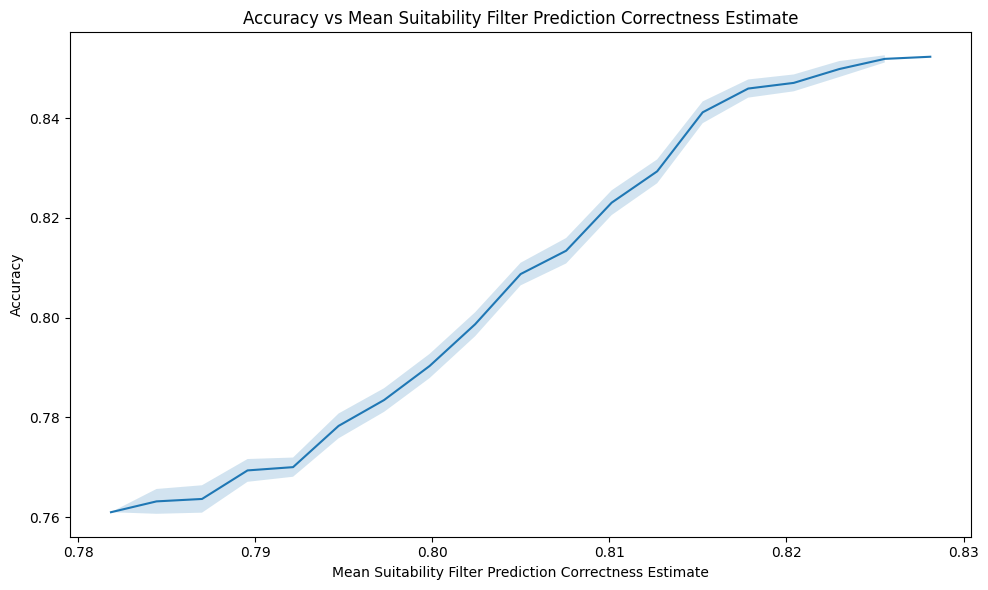

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem, t

# Define parameters
step_size = 0.01
test_acc = np.mean(test_corr)
accs = np.arange(
    test_acc - step_size / 2 - 4 * step_size,
    test_acc + step_size / 2 + 5 * step_size,
    step_size,
)

num_random_tries = 100
target_accuracies = accs
num_acc_folds = len(target_accuracies)
sample_size = 2500  # Only use sample size 2500

# Initialize storage for accuracies and sf_est values
all_accuracy_data = []
all_sf_est_data = []  # Store sf_est for sample size 2500

# Collect sf_est and accuracy data
for j in range(num_random_tries):
    folds, actual_accuracies = split_dataset_into_folds(
        all_user_corr, target_accuracies=target_accuracies
    )

    for i, fold_indices in enumerate(folds):
        fold_accuracy = actual_accuracies[i]

        # Collect sf_est data only for sample size 2500
        sf_estimate = sf_est[
            j, i, target_sample_sizes.tolist().index(sample_size), 0
        ]  # Use the first margin
        all_sf_est_data.append(sf_estimate)

        # Collect fold accuracy
        all_accuracy_data.append(fold_accuracy)

# Convert collected data to numpy arrays
all_accuracy_data = np.array(all_accuracy_data)
all_sf_est_data = np.array(all_sf_est_data)

# Define bins for sf_est values
fig, ax = plt.subplots(figsize=(10, 6))
bins = np.linspace(np.min(all_sf_est_data), np.max(all_sf_est_data), 20)
bin_centers = (bins[:-1] + bins[1:]) / 2
mean_accuracies = []
lower_confidence_intervals = []
upper_confidence_intervals = []

for i in range(len(bins) - 1):
    # Select data points within the bin
    bin_indices = (all_sf_est_data >= bins[i]) & (all_sf_est_data < bins[i + 1])
    bin_accuracies = all_accuracy_data[bin_indices]

    # Skip if the bin is empty
    if len(bin_accuracies) == 0:
        continue

    # Calculate mean and 95% confidence interval for accuracy
    mean_acc = np.mean(bin_accuracies)
    conf_int = sem(bin_accuracies) * t.ppf(0.975, len(bin_accuracies) - 1)  # 95% CI

    mean_accuracies.append(mean_acc)
    lower_confidence_intervals.append(mean_acc - conf_int)
    upper_confidence_intervals.append(mean_acc + conf_int)

# Plot the mean accuracy with 95% confidence interval for sample size 2500
ax.plot(
    bin_centers[: len(mean_accuracies)],
    mean_accuracies,
    label=f"Sample Size: {sample_size}",
)
ax.fill_between(
    bin_centers[: len(mean_accuracies)],
    lower_confidence_intervals,
    upper_confidence_intervals,
    alpha=0.2,
)

# ax.axhline(y=np.mean(test_corr), color='red', linestyle='--', linewidth=1.5, label='Test Accuracy')
# ax.axvline(x=np.mean(suitability_filter.suitability_test(user_features=all_user_features[:100], return_predictions=True)['test_predictions']), color='green', linestyle='--', linewidth=1.5, label='Test Regressor Prediction')

# Customize plot
ax.set_xlabel("Mean Suitability Filter Prediction Correctness Estimate")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Mean Suitability Filter Prediction Correctness Estimate")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

# Initialize result storage
results = []

# Loop over each sample size and each method
for s, num_samples in enumerate(target_sample_sizes):
    for method, estimates in zip(
        ["atc", "doc", "doe", "mde", "sf_est"], [atc, doc, doe, mde, sf_est]
    ):
        # Flatten arrays to match dimensions
        actuals = corrs.flatten()
        estimates_flat = estimates[:, :, s].flatten()

        # Calculate metrics
        mean_deviation = np.mean(np.abs(estimates_flat - actuals))
        r2 = r2_score(actuals, estimates_flat)
        spearman_corr, _ = spearmanr(actuals, estimates_flat)

        # Append results to the list
        results.append(
            {
                "Sample Size": num_samples,
                "Method": method,
                "Mean Deviation": mean_deviation,
                "R^2 Score": r2,
                "Spearman Correlation": spearman_corr,
            }
        )

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
display(results_df)

,Sample Size,Method,Mean Deviation,R^2 Score,Spearman Correlation
0,1000,atc,0.017923,0.503359,0.745813
1,1000,doc,0.022371,0.283860,0.743726
2,1000,doe,0.025167,0.101898,0.508656
3,1000,mde,0.862726,-808.518067,-0.119496
4,1000,sf_est,0.019140,0.445019,0.850678
5,1500,atc,0.017233,0.547342,0.818217
6,1500,doc,0.022200,0.292835,0.815278
7,1500,doe,0.025024,0.108860,0.602401
8,1500,mde,0.652428,-462.402801,-0.164976
9,1500,sf_est,0.018961,0.459689,0.898102


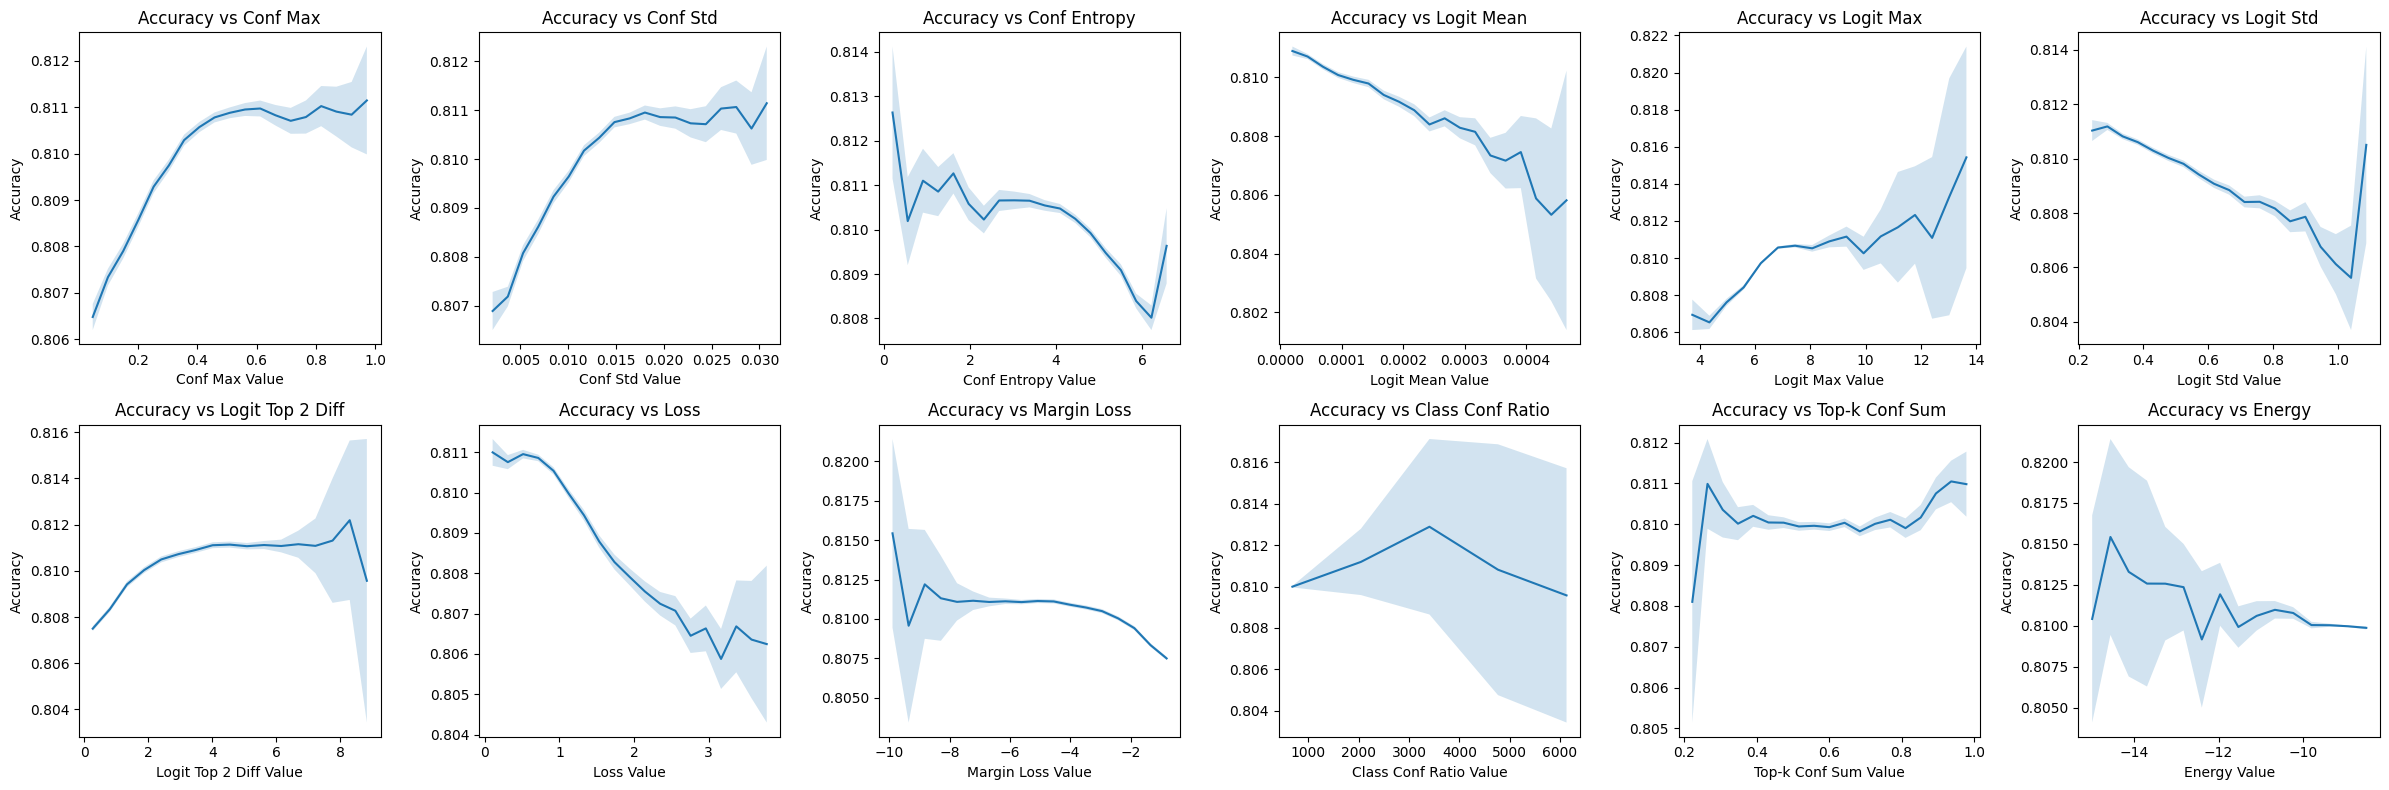

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem, t

# Define the feature names
features = np.array(
    [
        "Conf Max",
        "Conf Std",
        "Conf Entropy",
        "Logit Mean",
        "Logit Max",
        "Logit Std",
        "Logit Top 2 Diff",
        "Loss",
        "Margin Loss",
        "Class Conf Ratio",
        "Top-k Conf Sum",
        "Energy",
    ]
)

# Define parameters
step_size = 0.01
test_acc = np.mean(test_corr)
accs = np.arange(
    test_acc - step_size / 2 - 4 * step_size,
    test_acc + step_size / 2 + 5 * step_size,
    step_size,
)

num_random_tries = 100
target_accuracies = accs
num_acc_folds = len(target_accuracies)

# Initialize storage for accuracies and features
all_feature_data = {
    k: [] for k in range(all_user_features.shape[1])
}  # For storing features
all_accuracy_data = []
corrs = np.zeros((num_random_tries, num_acc_folds))

# Loop over random trials
for j in range(num_random_tries):
    folds, actual_accuracies = split_dataset_into_folds(
        all_user_corr, target_accuracies=target_accuracies
    )
    corrs[j] = np.array(actual_accuracies)

    # Loop over accuracy folds and collect features for each fold
    for i, fold_indices in enumerate(folds):
        user_features = all_user_features[fold_indices]
        fold_accuracy = actual_accuracies[i]

        # Store each feature for this fold and trial
        for k in range(user_features.shape[1]):
            all_feature_data[k].extend(
                user_features[:, k]
            )  # Collect feature data for each feature

        # Collect fold accuracy
        all_accuracy_data.extend([fold_accuracy] * user_features.shape[0])

# Convert collected accuracy data to numpy array
all_accuracy_data = np.array(all_accuracy_data)

# Plot the relationship between each feature and accuracy
num_features = len(features)  # Number of features to plot
fig, axs = plt.subplots(2, 6, figsize=(24, 8))  # 2 rows, 6 columns

for k in range(num_features):
    feature_values = np.array(all_feature_data[k])

    # Calculate the mean and confidence intervals for each feature bin
    bins = np.linspace(
        np.min(feature_values), np.max(feature_values), 20
    )  # Define 20 bins for features
    bin_centers = (bins[:-1] + bins[1:]) / 2
    mean_accuracies = []
    lower_confidence_intervals = []
    upper_confidence_intervals = []

    for i in range(len(bins) - 1):
        # Select data points within the bin
        bin_indices = (feature_values >= bins[i]) & (feature_values < bins[i + 1])
        bin_accuracies = all_accuracy_data[bin_indices]

        # Skip if the bin is empty
        if len(bin_accuracies) == 0:
            continue

        # Calculate mean and 95% confidence interval for accuracy
        mean_acc = np.mean(bin_accuracies)
        conf_int = sem(bin_accuracies) * t.ppf(0.975, len(bin_accuracies) - 1)  # 95% CI

        mean_accuracies.append(mean_acc)
        lower_confidence_intervals.append(mean_acc - conf_int)
        upper_confidence_intervals.append(mean_acc + conf_int)

    # Select appropriate subplot
    row, col = divmod(k, 6)
    axs[row, col].plot(
        bin_centers[: len(mean_accuracies)], mean_accuracies, label=features[k]
    )
    axs[row, col].fill_between(
        bin_centers[: len(mean_accuracies)],
        lower_confidence_intervals,
        upper_confidence_intervals,
        alpha=0.2,
    )
    axs[row, col].set_xlabel(f"{features[k]} Value")
    axs[row, col].set_ylabel("Accuracy")
    axs[row, col].set_title(f"Accuracy vs {features[k]}")

plt.tight_layout()
plt.show()

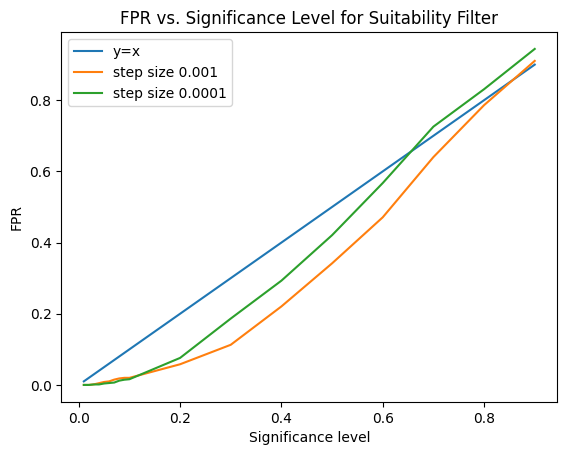

In [ ]:
x = [
    0.01,
    0.02,
    0.03,
    0.04,
    0.05,
    0.06,
    0.07,
    0.08,
    0.09,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
]
y = [get_fpr_fnr(p_vals[:, :, 3, 0] < sig_level, ground_truth)[0] for sig_level in x]
plt.plot(x, x, label="y=x")
plt.plot(x, step_size_001, label="step size 0.001")
plt.plot(x, y, label="step size 0.0001")
plt.xlabel("Significance level")
plt.ylabel("FPR")
plt.legend()
plt.title("FPR vs. Significance Level for Suitability Filter")
plt.show()

### Equivalence Test

In [ ]:
# Construct suitability filter
step_size = 0.05
test_acc = np.mean(test_corr)
accs = np.arange(
    test_acc - step_size / 2 - 4 * step_size,
    test_acc + step_size / 2 + 5 * step_size,
    step_size,
)

num_random_tries = 10
target_accuracies = accs  # np.arange(0.78, 0.83, 0.005), np.arange(0.798, 0.807, 0.001)
num_acc_folds = len(target_accuracies)
target_sample_sizes = np.array([1000, 1500, 2000, 2500])
num_sample_folds = len(target_sample_sizes)
target_margins = np.array([0.005, 0.01, 0.07])
num_margin_folds = len(target_margins)

ground_truth = np.zeros(
    (num_random_tries, num_acc_folds, num_acc_folds, num_sample_folds, num_margin_folds)
)
p_vals = np.zeros(
    (num_random_tries, num_acc_folds, num_acc_folds, num_sample_folds, num_margin_folds)
)
ac = np.zeros(
    (num_random_tries, num_acc_folds, num_acc_folds, num_sample_folds, num_margin_folds)
)
atc = np.zeros(
    (num_random_tries, num_acc_folds, num_acc_folds, num_sample_folds, num_margin_folds)
)
doc = np.zeros(
    (num_random_tries, num_acc_folds, num_acc_folds, num_sample_folds, num_margin_folds)
)


for r in range(num_random_tries):
    print(f"Random try {r}")
    folds, actual_accuracies = split_dataset_into_folds(
        all_user_corr, target_accuracies=target_accuracies
    )

    for i, fold_indices_1 in enumerate(folds):
        for j, fold_indices_2 in enumerate(folds):
            user_features_1 = all_user_features[fold_indices_1]
            user_features_2 = all_user_features[fold_indices_2]

            user_conf_1 = user_features_1[:, 1]
            user_conf_2 = user_features_2[:, 1]

            user_corr_1 = all_user_corr[fold_indices_1]
            user_corr_2 = all_user_corr[fold_indices_2]

            for s, num_samples in enumerate(target_sample_sizes):
                np.random.shuffle(user_features_1)
                np.random.shuffle(user_features_2)

                for m, margin in enumerate(target_margins):
                    if np.abs(np.mean(user_corr_1) - np.mean(user_corr_2)) > margin:
                        ground_truth[r, i, j, s, m] = 0
                    else:
                        ground_truth[r, i, j, s, m] = 1

                    ac1 = average_confidence.evaluate(
                        user_confidences=user_conf_1[:num_samples]
                    )
                    ac2 = average_confidence.evaluate(
                        user_confidences=user_conf_2[:num_samples]
                    )
                    ac[r, i, j, s, m] = np.abs(ac1 - ac2) <= margin

                    atc1 = average_threshold_confidence.evaluate(
                        user_confidences=user_conf_1[:num_samples]
                    )
                    atc2 = average_threshold_confidence.evaluate(
                        user_confidences=user_conf_2[:num_samples]
                    )
                    atc[r, i, j, s, m] = np.abs(atc1 - atc2) <= margin

                    doc1 = difference_of_confidence.estimate_performance(
                        user_confidences=user_conf_1[:num_samples]
                    )
                    doc2 = difference_of_confidence.estimate_performance(
                        user_confidences=user_conf_2[:num_samples]
                    )
                    doc[r, i, j, s, m] = np.abs(doc1 - doc2) <= margin

                    test = suitability_filter.performance_equivalence_test(
                        user_features_1=user_features_1[:num_samples],
                        user_features_2=user_features_2[:num_samples],
                        margin=margin,
                    )
                    p_vals[r, i, j, s, m] = max(
                        test["p_value_low"], test["p_value_upp"]
                    )

Random try 0
Random try 1
Random try 2
Random try 3
Random try 4
Random try 5
Random try 6
Random try 7
Random try 8
Random try 9


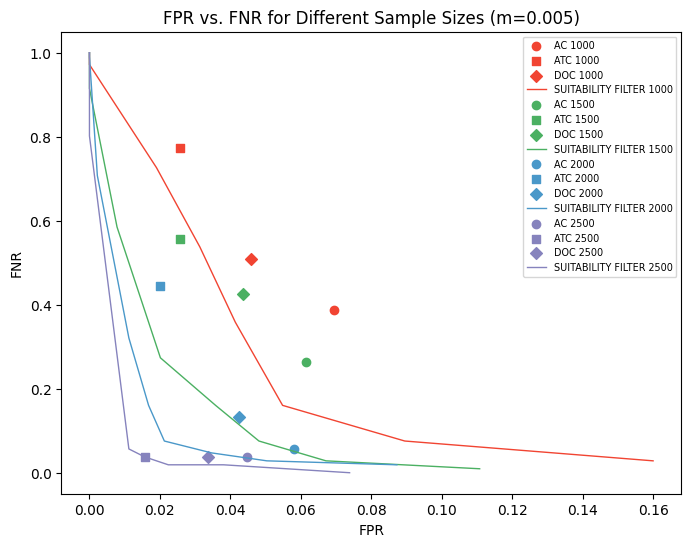

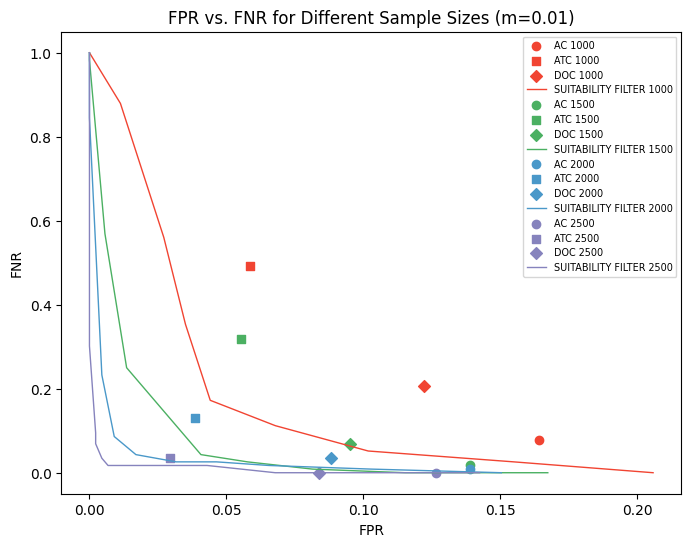

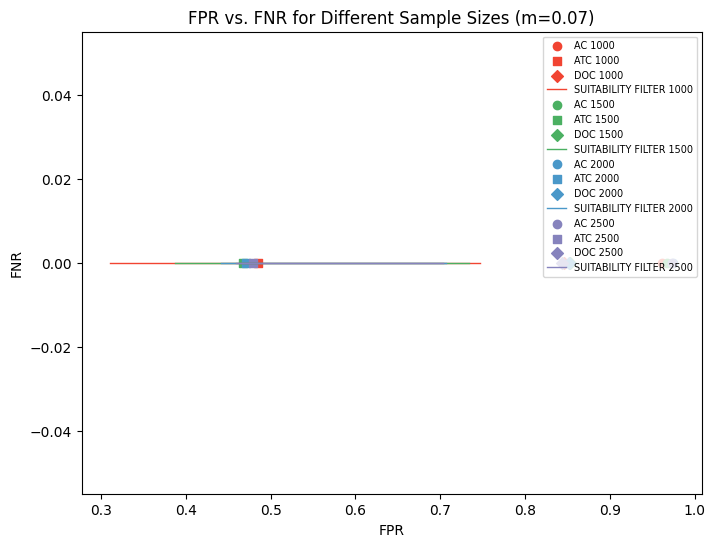

In [ ]:
# Color maps for each sample size
colors = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
markers = ["o", "s", "D"]  # Circle for AC, square for ATC, diamond for DOC


def get_fpr_fnr(decisions, ground_truth):
    decisions, ground_truth = decisions.flatten(), ground_truth.flatten()
    fpr = np.sum(np.logical_and(decisions == 1, ground_truth == 0)) / np.sum(
        ground_truth == 0
    )
    fnr = np.sum(np.logical_and(decisions == 0, ground_truth == 1)) / np.sum(
        ground_truth == 1
    )
    return fpr, fnr


for m in range(num_margin_folds):
    plt.figure(figsize=(8, 6))  # Create a new figure for each margin

    for s, num_samples in enumerate(target_sample_sizes):
        # Select color based on sample size
        color = colors[s](0.6)  # Adjust the hue to your preference

        # Plot each method with a different marker
        fpr_fnr_ac = get_fpr_fnr(ac[:, :, :, s, m], ground_truth[:, :, :, s, m])
        plt.scatter(
            *fpr_fnr_ac, label=f"AC {num_samples}", color=color, marker=markers[0]
        )

        fpr_fnr_atc = get_fpr_fnr(atc[:, :, :, s, m], ground_truth[:, :, :, s, m])
        plt.scatter(
            *fpr_fnr_atc, label=f"ATC {num_samples}", color=color, marker=markers[1]
        )

        fpr_fnr_doc = get_fpr_fnr(doc[:, :, :, s, m], ground_truth[:, :, :, s, m])
        plt.scatter(
            *fpr_fnr_doc, label=f"DOC {num_samples}", color=color, marker=markers[2]
        )

        # Calculate and plot the suitability filter line
        sf_fpr, sf_fnr = [], []
        for sig_level in [
            0.01,
            0.02,
            0.03,
            0.04,
            0.05,
            0.06,
            0.07,
            0.08,
            0.09,
            0.1,
            0.2,
            0.3,
            0.4,
            0.5,
            0.6,
            0.7,
            0.8,
            0.9,
        ]:
            fpr, fnr = get_fpr_fnr(
                p_vals[:, :, :, s, m] < sig_level, ground_truth[:, :, :, s, m]
            )
            sf_fpr.append(fpr)
            sf_fnr.append(fnr)

        plt.plot(
            sf_fpr,
            sf_fnr,
            color=color,
            linestyle="-",
            linewidth=1,
            label=f"SUITABILITY FILTER {num_samples}",
        )

    # Set labels and title for each plot
    plt.xlabel("FPR")
    plt.ylabel("FNR")
    plt.title(f"FPR vs. FNR for Different Sample Sizes (m={target_margins[m]})")
    plt.legend(fontsize="x-small")
    plt.show()


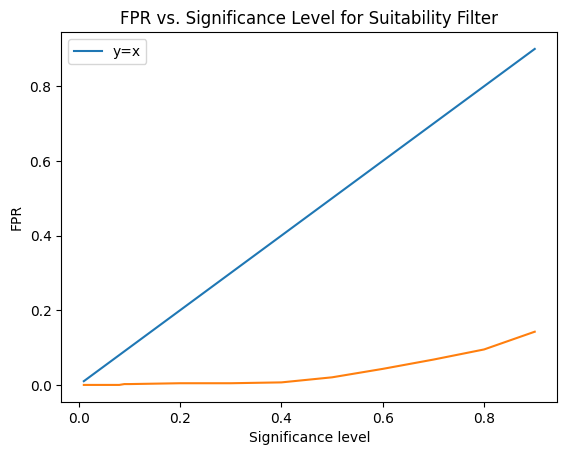

In [ ]:
x = [
    0.01,
    0.02,
    0.03,
    0.04,
    0.05,
    0.06,
    0.07,
    0.08,
    0.09,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
]
y = [
    get_fpr_fnr(p_vals[:, :, :, 3, 1] < sig_level, ground_truth[:, :, :, 3, 1])[0]
    for sig_level in x
]
plt.plot(x, x, label="y=x")
plt.plot(x, y)
plt.xlabel("Significance level")
plt.ylabel("FPR")
plt.legend()
plt.title("FPR vs. Significance Level for Suitability Filter")
plt.show()

## Compare individual signals with regressor

In [6]:
# Construct suitability filter
step_size = 0.01
test_acc = np.mean(test_corr)
accs = np.arange(
    test_acc - step_size / 2 - 4 * step_size,
    test_acc + step_size / 2 + 5 * step_size,
    step_size,
)

num_random_tries = 100
target_accuracies = accs  # np.arange(0.78, 0.83, 0.005), np.arange(0.798, 0.807, 0.001)
num_acc_folds = len(target_accuracies)
target_sample_sizes = np.array([1000, 1500, 2000, 2500])
num_sample_folds = len(target_sample_sizes)

corrs = np.zeros((num_random_tries, num_acc_folds))
p_vals_sf = np.zeros((num_random_tries, num_acc_folds, num_sample_folds))
p_vals_feat = np.zeros((np.shape(all_user_features)[1], num_random_tries, num_acc_folds, num_sample_folds))
p_vals_feat_reg = np.zeros((np.shape(all_user_features)[1], num_random_tries, num_acc_folds, num_sample_folds))

for j in range(num_random_tries):
    folds, actual_accuracies = split_dataset_into_folds(
        all_user_corr, target_accuracies=target_accuracies
    )
    corrs[j] = np.array(actual_accuracies)

    for i, fold_indices in enumerate(folds):
        user_features = all_user_features[fold_indices]

        user_conf = user_features[:, 0]
        user_entropy = user_features[:, 2]
        user_energy = user_features[:, -1]
        user_corr = all_user_corr[fold_indices]

        for s, num_samples in enumerate(target_sample_sizes):
            np.random.shuffle(user_features)

            p_vals_sf[j, i, s] = suitability_filter.suitability_test(
                user_features=user_features[:num_samples],
                margin=0
            )["p_value"]
            feat_test = suitability_filter.suitability_test_for_individual_features(user_features=user_features[:num_samples])

            for fi, test in enumerate(feat_test):
                p_vals_feat[fi, j, i, s] = test["p_value"]
                p_vals_feat_reg[fi, j, i, s] = suitability_filter.suitability_test_for_feature_subset(feature_subset=[fi], user_features=user_features[:num_samples])["p_value"]

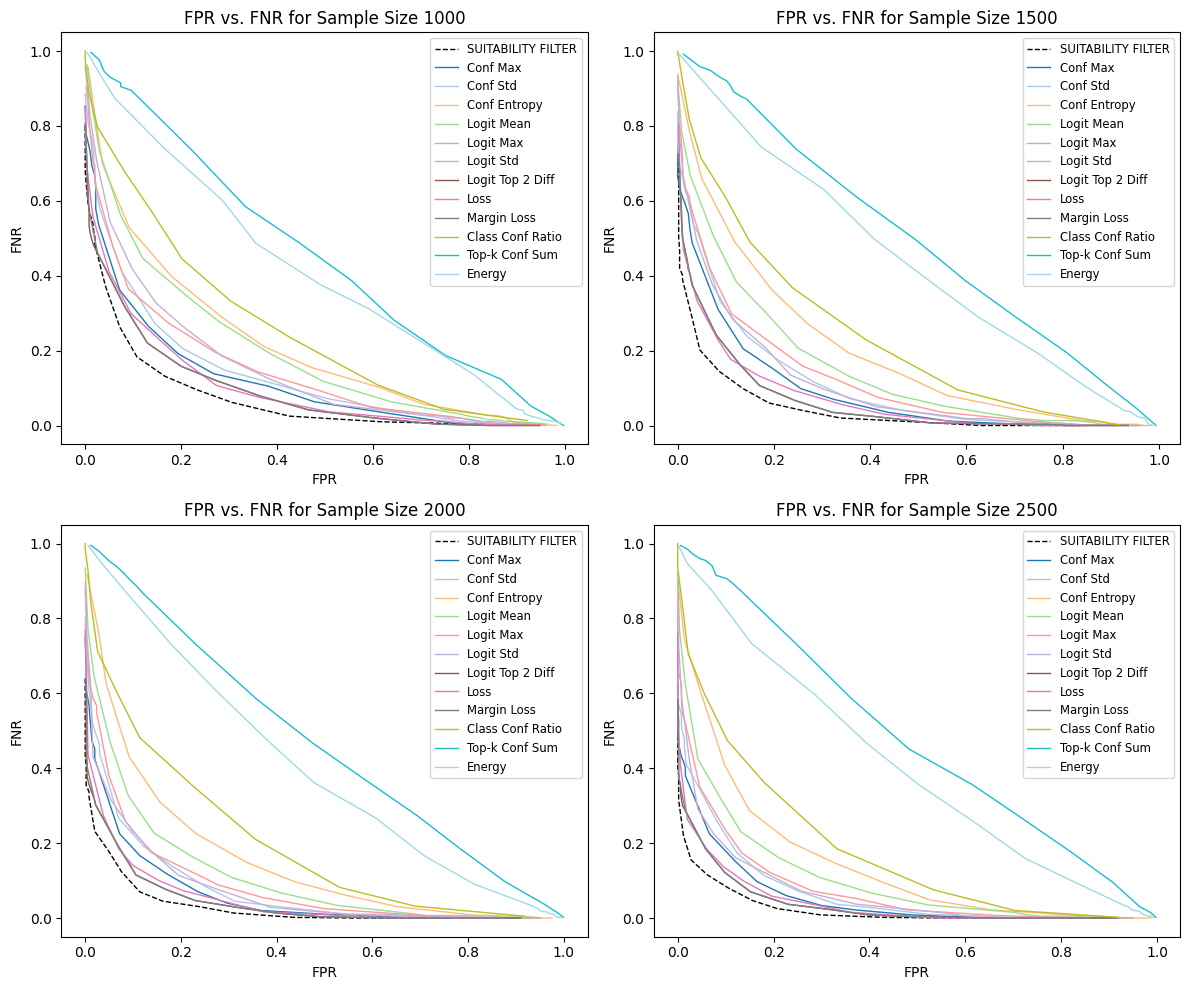

In [ ]:
# Define feature names
features = np.array(
    [
        "Conf Max",
        "Conf Std",
        "Conf Entropy",
        "Logit Mean",
        "Logit Max",
        "Logit Std",
        "Logit Top 2 Diff",
        "Loss",
        "Margin Loss",
        "Class Conf Ratio",
        "Top-k Conf Sum",
        "Energy",
    ]
)

# Color maps for each method (distinct colors for each feature)
feature_colors = plt.get_cmap("tab20", len(features))  # 'tab20' provides 20 distinct colors

# Construct ground truth
ground_truth = corrs >= np.mean(test_corr)

def get_fpr_fnr(decisions, ground_truth):
    decisions, ground_truth = decisions.flatten(), ground_truth.flatten()
    fpr = np.sum(np.logical_and(decisions == 1, ground_truth == 0)) / np.sum(
        ground_truth == 0
    )
    fnr = np.sum(np.logical_and(decisions == 0, ground_truth == 1)) / np.sum(
        ground_truth == 1
    )
    return fpr, fnr


# Create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for s, num_samples in enumerate(target_sample_sizes):
    ax = axes[s]

    # Plot suitability filter line for the sample size
    sf_fpr = []
    sf_fnr = []
    ground_truth = corrs >= np.mean(test_corr)
    for sig_level in [
        0.01,
        0.02,
        0.03,
        0.04,
        0.05,
        0.06,
        0.07,
        0.08,
        0.09,
        0.1,
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.8,
        0.9,
        0.95,
        0.99,
    ]:
        fpr, fnr = get_fpr_fnr(p_vals_sf[:, :, s] < sig_level, ground_truth)
        sf_fpr.append(fpr)
        sf_fnr.append(fnr)

    # Plot suitability filter line with different style (black dashed line)
    ax.plot(
        sf_fpr,
        sf_fnr,
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"SUITABILITY FILTER",
    )

    # Plot feature-specific lines for all features
    for fi, feature in enumerate(features):
        feature_fpr = []
        feature_fnr = []
        for sig_level in [
            0.01,
            0.02,
            0.03,
            0.04,
            0.05,
            0.06,
            0.07,
            0.08,
            0.09,
            0.1,
            0.2,
            0.3,
            0.4,
            0.5,
            0.6,
            0.7,
            0.8,
            0.9,
            0.95,
            0.99,
        ]:
            if fi in [0, 1, 4, 6, 9, 10]:
                fpr, fnr = get_fpr_fnr(p_vals_feat[fi, :, :, s] < sig_level, ground_truth)
            else:
                fpr, fnr = get_fpr_fnr(p_vals_feat[fi, :, :, s] > sig_level, ground_truth)
            feature_fpr.append(fpr)
            feature_fnr.append(fnr)

        # Plot feature line with a unique color
        ax.plot(
            feature_fpr,
            feature_fnr,
            color=feature_colors(fi),
            linestyle="-",
            linewidth=1,
            label=feature,
        )

    # Labels and title for each subplot
    ax.set_xlabel("FPR")
    ax.set_ylabel("FNR")
    ax.set_title(f"FPR vs. FNR for Sample Size {num_samples}")
    ax.legend(fontsize="small", loc="best")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


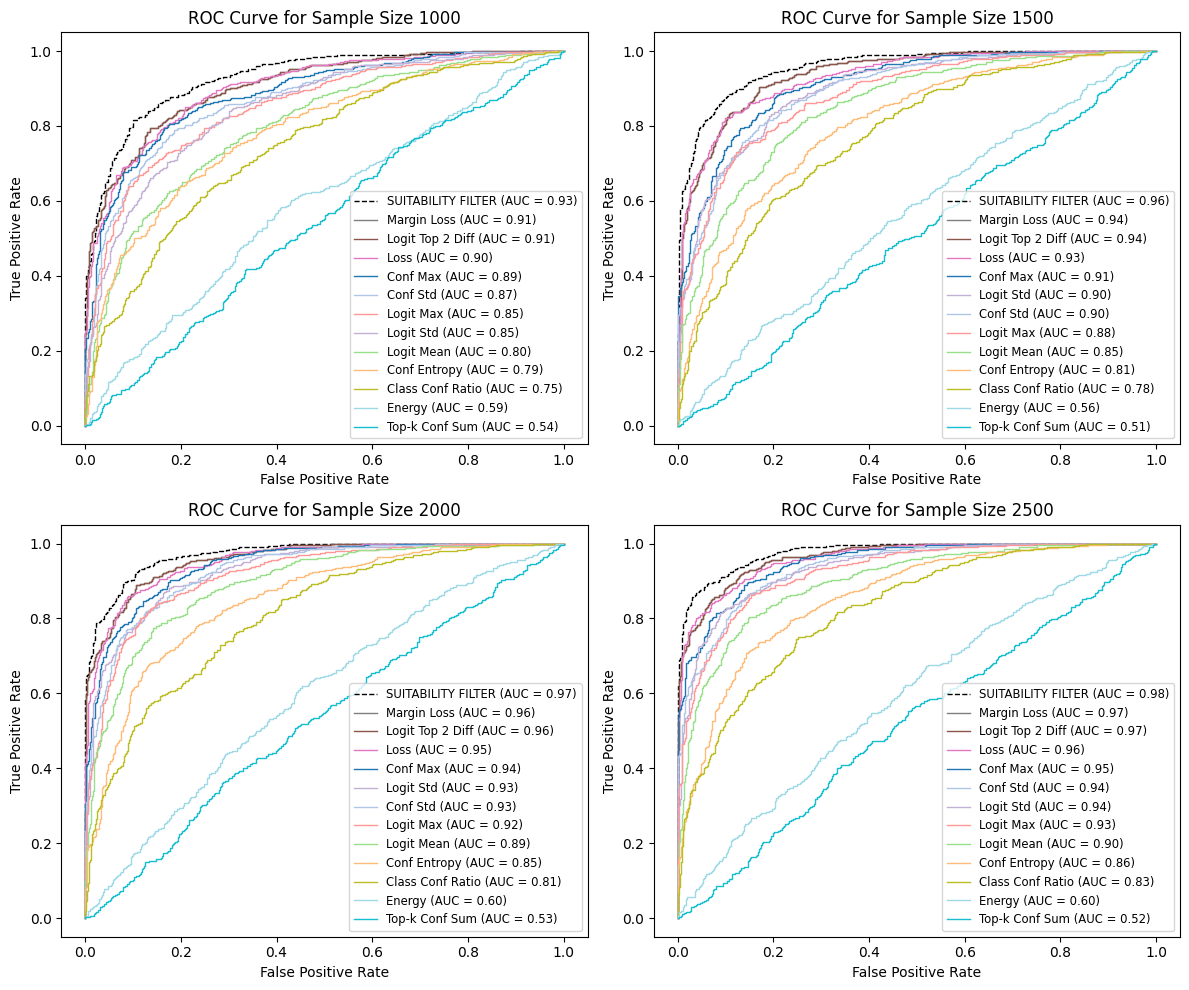

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define feature names
features = np.array(
    [
        "Conf Max",
        "Conf Std",
        "Conf Entropy",
        "Logit Mean",
        "Logit Max",
        "Logit Std",
        "Logit Top 2 Diff",
        "Loss",
        "Margin Loss",
        "Class Conf Ratio",
        "Top-k Conf Sum",
        "Energy",
    ]
)

# Color maps for each method (distinct colors for each feature)
feature_colors = plt.get_cmap("tab20", len(features))  # 'tab20' provides 20 distinct colors

# Construct ground truth
ground_truth = corrs >= np.mean(test_corr)

# Function to compute TPR and FPR
def get_tpr_fpr(p_vals, ground_truth):
    fpr, tpr, _ = roc_curve(ground_truth.flatten(), p_vals.flatten())
    return fpr, tpr

# Create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for s, num_samples in enumerate(target_sample_sizes):
    ax = axes[s]

    # Plot suitability filter ROC curve for the sample size
    sf_fpr, sf_tpr = get_tpr_fpr(-p_vals_sf[:, :, s], ground_truth)
    sf_auc = auc(sf_fpr, sf_tpr)

    # Plot suitability filter line (black dashed line)
    ax.plot(
        sf_fpr,
        sf_tpr,
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"SUITABILITY FILTER (AUC = {sf_auc:.2f})",
    )

    # Collect features and AUCs for sorting
    legend_entries = []
    auc_scores = []

    # Plot feature-specific ROC curves
    for fi, feature in enumerate(features):
        # Get TPR and FPR for each feature at the sample size
        if fi in [0, 1, 4, 6, 9, 10]:
            fpr, tpr = get_tpr_fpr(-p_vals_feat[fi, :, :, s], ground_truth)
        else:
            fpr, tpr = get_tpr_fpr(p_vals_feat[fi, :, :, s], ground_truth)

        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)
        legend_entries.append((f"{feature} (AUC = {auc_score:.2f})", fpr, tpr, feature_colors(fi)))

    # Sort the entries by AUC in descending order
    sorted_entries = sorted(zip(auc_scores, legend_entries), reverse=True)

    # Plot the sorted legend entries
    for auc_score, entry in sorted_entries:
        label, fpr, tpr, color = entry
        ax.plot(fpr, tpr, color=color, linestyle="-", linewidth=1, label=label)

    # Labels and title for each subplot
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve for Sample Size {num_samples}")
    
    # Add the legend with sorted entries
    ax.legend(fontsize="small", loc="best")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


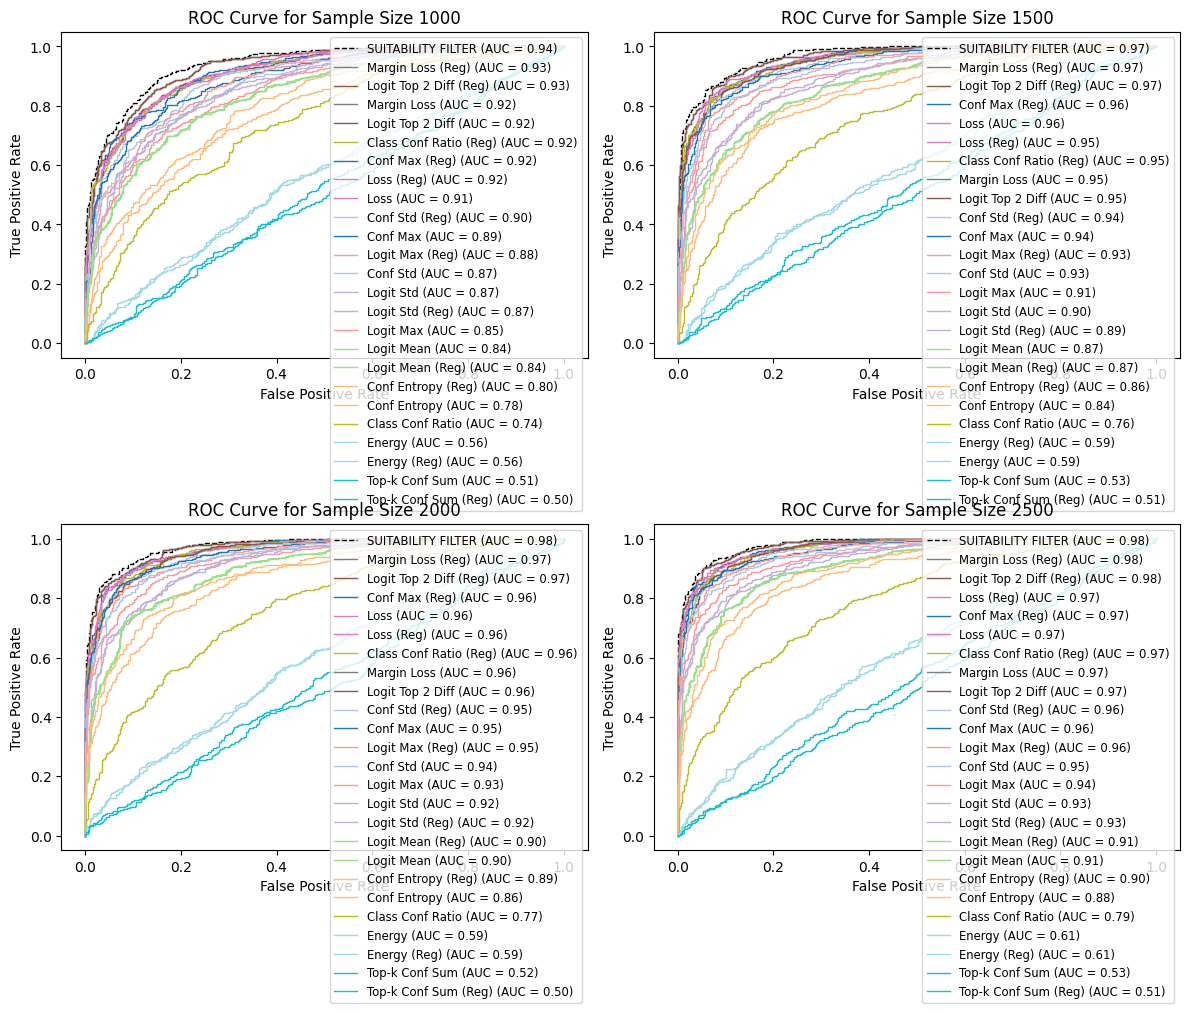

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define feature names
features = np.array(
    [
        "Conf Max",
        "Conf Std",
        "Conf Entropy",
        "Logit Mean",
        "Logit Max",
        "Logit Std",
        "Logit Top 2 Diff",
        "Loss",
        "Margin Loss",
        "Class Conf Ratio",
        "Top-k Conf Sum",
        "Energy",
    ]
)

# Color maps for each method (distinct colors for each feature)
feature_colors = plt.get_cmap("tab20", len(features))  # 'tab20' provides 20 distinct colors

# Construct ground truth
ground_truth = corrs >= np.mean(test_corr)

# Function to compute TPR and FPR
def get_tpr_fpr(p_vals, ground_truth):
    fpr, tpr, _ = roc_curve(ground_truth.flatten(), p_vals.flatten())
    return fpr, tpr

# Create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for s, num_samples in enumerate(target_sample_sizes):
    ax = axes[s]

    # Plot suitability filter ROC curve for the sample size
    sf_fpr, sf_tpr = get_tpr_fpr(-p_vals_sf[:, :, s], ground_truth)
    sf_auc = auc(sf_fpr, sf_tpr)

    # Plot suitability filter line (black dashed line)
    ax.plot(
        sf_fpr,
        sf_tpr,
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"SUITABILITY FILTER (AUC = {sf_auc:.2f})",
    )

    # Collect features and AUCs for sorting
    legend_entries = []
    auc_scores = []

    # Plot feature-specific ROC curves
    for fi, feature in enumerate(features):
        # Get TPR and FPR for each feature at the sample size
        if fi in [0, 1, 4, 6, 9, 10]:
            fpr, tpr = get_tpr_fpr(-p_vals_feat[fi, :, :, s], ground_truth)
        else:
            fpr, tpr = get_tpr_fpr(p_vals_feat[fi, :, :, s], ground_truth)

        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)
        legend_entries.append((f"{feature} (AUC = {auc_score:.2f})", fpr, tpr, feature_colors(fi)))

        fpr, tpr = get_tpr_fpr(-p_vals_feat_reg[fi, :, :, s], ground_truth)
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)
        legend_entries.append((f"{feature} (Reg) (AUC = {auc_score:.2f})", fpr, tpr, feature_colors(fi)))

    # Sort the entries by AUC in descending order
    sorted_entries = sorted(zip(auc_scores, legend_entries), reverse=True)

    # Plot the sorted legend entries
    for auc_score, entry in sorted_entries:
        label, fpr, tpr, color = entry
        ax.plot(fpr, tpr, color=color, linestyle="-", linewidth=1, label=label)

    # Labels and title for each subplot
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve for Sample Size {num_samples}")
    
    # Add the legend with sorted entries
    ax.legend(fontsize="small", loc="best")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


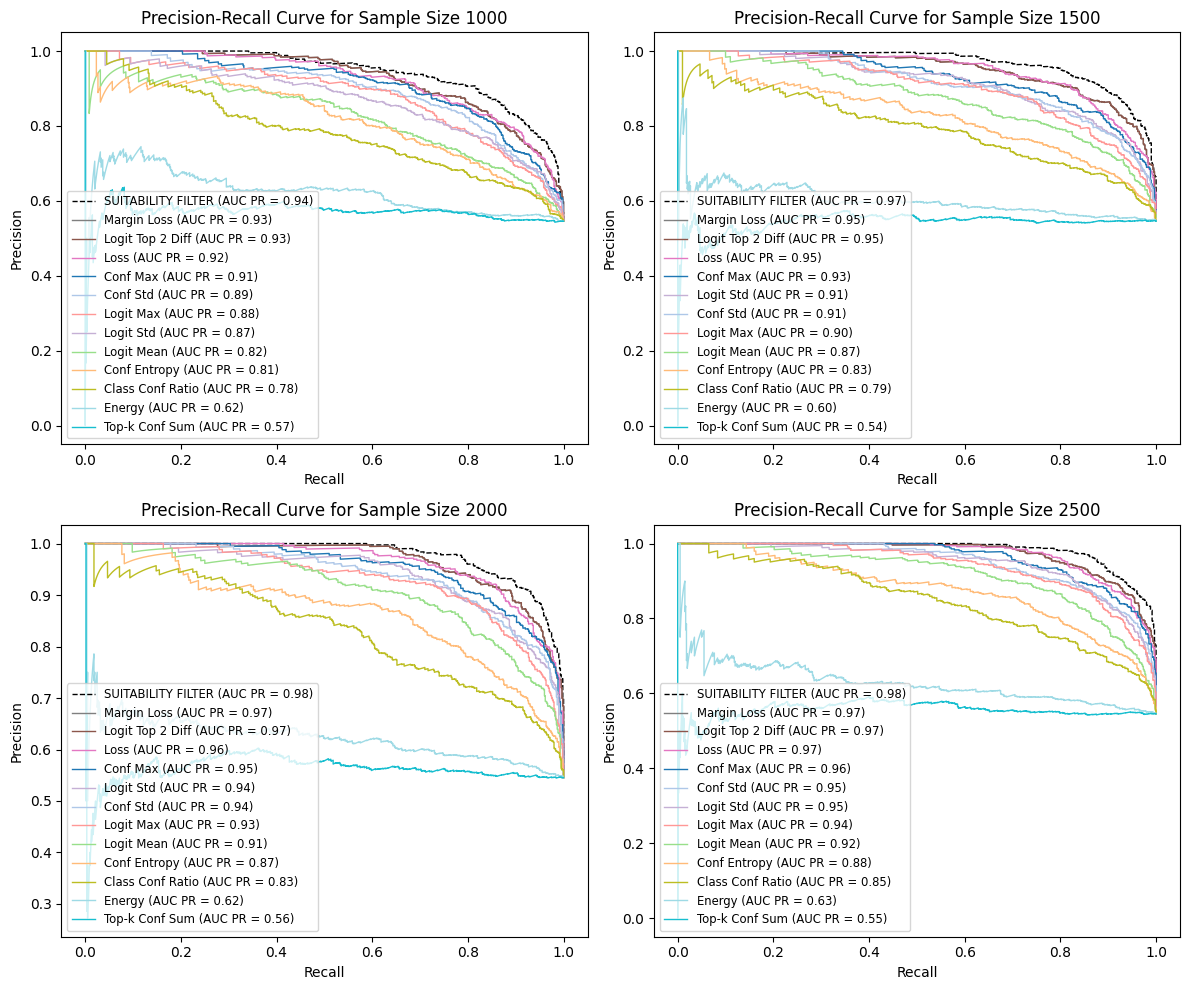

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Define feature names
features = np.array(
    [
        "Conf Max",
        "Conf Std",
        "Conf Entropy",
        "Logit Mean",
        "Logit Max",
        "Logit Std",
        "Logit Top 2 Diff",
        "Loss",
        "Margin Loss",
        "Class Conf Ratio",
        "Top-k Conf Sum",
        "Energy",
    ]
)

# Color maps for each method (distinct colors for each feature)
feature_colors = plt.get_cmap("tab20", len(features))  # 'tab20' provides 20 distinct colors

# Construct ground truth
ground_truth = corrs >= np.mean(test_corr)

# Function to compute Precision and Recall
def get_precision_recall(p_vals, ground_truth):
    precision, recall, _ = precision_recall_curve(ground_truth.flatten(), p_vals.flatten())
    return precision, recall

# Create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for s, num_samples in enumerate(target_sample_sizes):
    ax = axes[s]

    # Plot suitability filter PR curve for the sample size
    sf_precision, sf_recall = get_precision_recall(-p_vals_sf[:, :, s], ground_truth)
    sf_auc_pr = auc(sf_recall, sf_precision)

    # Plot suitability filter line (black dashed line)
    ax.plot(
        sf_recall,
        sf_precision,
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"SUITABILITY FILTER (AUC PR = {sf_auc_pr:.2f})",
    )

    # Collect features and AUCs for sorting
    legend_entries = []
    auc_pr_scores = []

    # Plot feature-specific PR curves
    for fi, feature in enumerate(features):
        # Get Precision and Recall for each feature at the sample size
        if fi in [0, 1, 4, 6, 9, 10]:
            precision, recall = get_precision_recall(-p_vals_feat[fi, :, :, s], ground_truth)
        else:
            precision, recall = get_precision_recall(p_vals_feat[fi, :, :, s], ground_truth)

        auc_pr_score = auc(recall, precision)
        auc_pr_scores.append(auc_pr_score)
        legend_entries.append((f"{feature} (AUC PR = {auc_pr_score:.2f})", recall, precision, feature_colors(fi)))

    # Sort the entries by AUC PR in descending order
    sorted_entries = sorted(zip(auc_pr_scores, legend_entries), reverse=True)

    # Plot the sorted legend entries
    for auc_pr_score, entry in sorted_entries:
        label, recall, precision, color = entry
        ax.plot(recall, precision, color=color, linestyle="-", linewidth=1, label=label)

    # Labels and title for each subplot
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve for Sample Size {num_samples}")
    
    # Add the legend with sorted entries
    ax.legend(fontsize="small", loc="best")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()